# Combining tides with satellite data

This guide demonstrates how to combine tide modelling with satellite Earth observation (EO) data using the [`tag_tides`](../../api/#eo_tides.eo.tag_tides) and [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides) functions from [`eo_tides.eo`](../../api/#eo_tides.eo). 

Both these functions allow you to model the height of the tide at the exact moment of satellite image acquisition. 
This can then allow you to analyse satellite EO data by tidal conditions - for example, filter your data to satellite imagery collected during specific tidal stages (e.g. low or high tide).

Although both functions perform a similar function, they differ in complexity and performance. `tag_tides` assigns a single tide height to each timestep/satellite image, which is fast and efficient, and suitable for small-scale applications where tides are unlikely to vary across your study area. In constrast, `pixel_tide` models tides both through time *and* spatially, returning a tide height for every satellite pixel. This can be critical for producing seamless coastal EO datasets at large scale - however comes at the cost of performance.
<br><br>
> **Table 1.** Comparison of `tag_tides` and `pixel_tides`

| [`tag_tides`](../../api/#eo_tides.eo.tag_tides)                                                                 | [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides)                                                                                              |
|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Assigns a single tide height to each timestep/satellite image                         | Assigns a tide height to every individual pixel through time to capture spatial tide dynamics                                               |
| 🔎 Ideal for local or site-scale analysis                                      | 🌏 Ideal for regional to global-scale coastal product generation                                              |
| ✅ Fast, low memory use                                                        | ❌ Slower, higher memory use                                                                                  |
| ❌ Single tide height per image can produce artefacts in complex tidal regions | ✅ Produce spatially seamless results across large extents by applying analyses at the pixel level |

## Load satellite data using odc-stac

First, we will load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package.
This powerful package allows us to load open satellite data (e.g ESA Sentinel-2 or NASA/USGS Landsat) for any time period and location on the planet, and load our data into a multi-dimensional `xarray.Dataset` format dataset.

In this example, we will load **Landsat 8 and 9** satellite data from **2024** over the city of **Broome, Western Australia** - a macrotidal region with extensive intertidal coastal habitats.
We will load this data from the [Digital Earth Australia](https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/) STAC catalogue.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to the <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">Digital Earth Australia STAC user guide</a>.
    </p>
</div>

In [1]:
import odc.stac
import pystac_client

# Connect to STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.12, -18.25, 122.43, -17.93]
query = catalog.search(
    bbox=bbox,
    collections=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    datetime="2024-01-01/2024-12-31",
    filter = "eo:cloud_cover < 5"  # Filter to images with <5% cloud
)

# Load data into xarray format
ds = odc.stac.load(
    items=list(query.items()),
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

# Plot the first image
ds.isel(time=0).odc.explore(vmin=50, vmax=3000)

/workspaces/eo-tides/.venv/lib/python3.11/site-packages/odc/geo/_rgba.py:56: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")
/workspaces/eo-tides/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


## Using tag_tides

We can pass our satellite dataset `ds` to the `tag_tides` function to model a tide for each timestep in our dataset.
This can help sort and filter images by tide height, allowing us to learn more about how coastal environments respond to the effect of changing tides.

The `tag_tides` function uses the time and date of acquisition and the geographic location of each satellite observation as inputs for the selected tide model (EOT20 by default).

In [2]:
from eo_tides.eo import tag_tides

ds = tag_tides(
    ds=ds,
    directory="../../tests/data/tide_models",
)

Setting tide modelling location from dataset centroid: 122.27, -18.09
Modelling tides using EOT20


Our output data now has a new `tide_height` variable under **Data variables**:

In [3]:
print(ds)

<xarray.Dataset> Size: 688MB
Dimensions:      (y: 1185, x: 1099, time: 44)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.397e+05 4.398e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 352B 2024-01-07T01:55:31.679580 ... 20...
Data variables:
    nbart_red    (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_green  (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    tide_height  (time) float32 176B -0.2511 0.5276 1.517 ... 0.7157 -0.03352


We can plot this new `tide_height` variable to inspect the range of tide heights observed by the satellites in our time series:

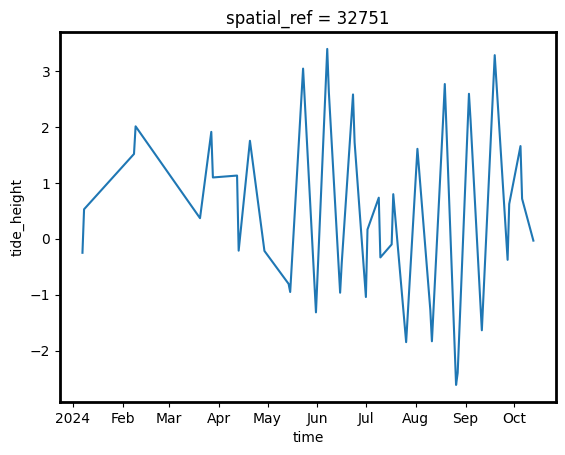

In [4]:
ds.tide_height.plot();

### Modelling ebb and flow tidal phases
The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

Once you run the cell below, our data will now also contain a new `ebb_flow` variable under **Data variables**:

In [5]:
# Model tide heights
ds = tag_tides(
    ds, 
    ebb_flow=True,     
    directory="../../tests/data/tide_models",
)

# Print output data
print(ds)

Setting tide modelling location from dataset centroid: 122.27, -18.09
Modelling tides using EOT20
Modelling tidal phase (e.g. ebb or flow)
Modelling tides using EOT20
<xarray.Dataset> Size: 688MB
Dimensions:      (y: 1185, x: 1099, time: 44)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.397e+05 4.398e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 352B 2024-01-07T01:55:31.679580 ... 20...
Data variables:
    nbart_red    (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_green  (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    tide_height  (time) float32 176B -0.2511 0.5276 1.517 ... 0.7157 -0.03352
    ebb_flow     (time) object 352B 'Ebb' 'Ebb' 'Flow' ... 'Flow' 'Flow' 'Ebb'


We now have data giving us the both the tide height and tidal phase ("ebb" or "flow") for every satellite image:

In [6]:
ds[["time", "tide_height", "ebb_flow"]].drop_vars("spatial_ref").to_dataframe().head()

,tide_height,ebb_flow
time,,
2024-01-07 01:55:31.679580,-0.251089,Ebb
2024-01-08 01:49:36.716728,0.527567,Ebb
2024-02-08 01:56:00.413098,1.517171,Flow
2024-02-09 01:49:37.113806,2.011433,Flow
2024-03-20 01:49:39.697193,0.368091,Flow


We could for example use this data to filter our observations to keep ebbing phase observations only:

In [7]:
ds_ebb = ds.where(ds.ebb_flow == "Ebb", drop=True)
print(ds_ebb)

<xarray.Dataset> Size: 219MB
Dimensions:      (time: 14, y: 1185, x: 1099)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.397e+05 4.398e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 112B 2024-01-07T01:55:31.679580 ... 20...
Data variables:
    nbart_red    (time, y, x) float32 73MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_green  (time, y, x) float32 73MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 73MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    tide_height  (time) float32 56B -0.2511 0.5276 1.753 ... 0.6212 -0.03352
    ebb_flow     (time) object 112B 'Ebb' 'Ebb' 'Ebb' ... 'Ebb' 'Ebb' 'Ebb'


### Swapping dimensions
The `tag_tides` function allows you to use tide height as the primary dimension in the dataset, instead of time. Setting `swap_dims=True` will swap the time dimension in the original `xarray.Dataset` to the new `tide_height` variable.

This will produce a dataset containing three **dimensions**: `y`, `x` and `tide_height`.

In [8]:
# Model tide heights
ds_swapped = tag_tides(
    ds, 
    swap_dims=True,     
    directory="../../tests/data/tide_models",
)

# Print output data
print(ds_swapped)

Setting tide modelling location from dataset centroid: 122.27, -18.09
Modelling tides using EOT20
<xarray.Dataset> Size: 688MB
Dimensions:      (y: 1185, x: 1099, tide_height: 44)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.397e+05 4.398e+05
    spatial_ref  int32 4B 32751
  * tide_height  (tide_height) float32 176B -2.615 -2.399 -1.85 ... 3.285 3.396
Data variables:
    nbart_red    (tide_height, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_green  (tide_height, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_blue   (tide_height, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    ebb_flow     (tide_height) object 352B 'Flow' 'Flow' ... 'Flow' 'Flow'


Using tide height as a dimension can make it easier to analyse the data with respect to tide, e.g. plotting the lowest and highest tide image in our dataset:

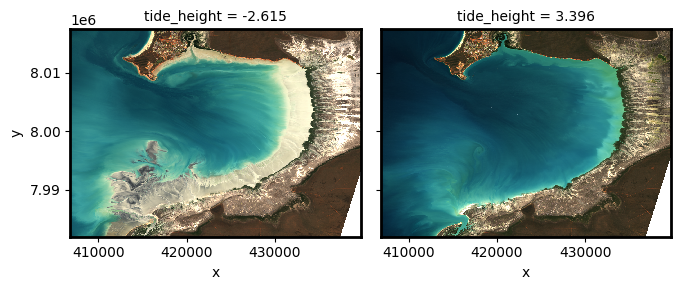

In [9]:
ds_swapped.isel(tide_height=[0, -1]).odc.to_rgba(vmin=50, vmax=3000).plot.imshow(col="tide_height")

## Using pixel_tides

The previous examples show how to model a single tide height for each satellite image using the centroid of the image as a tide modelling location.
However, in reality tides vary spatially – potentially by several metres in areas of complex tidal dynamics.
This means that an individual satellite image can capture a range of tide conditions.

We can use the `pixel_tides` function to capture this spatial variability in tide heights. 
For efficient processing, this function first models tides into a low resolution grid surrounding each satellite image in our time series.
This lower resolution data includes a buffer around the extent of our satellite data so that tides can be modelled seamlessly across analysis boundaries.

First, let's reload our satellite data for a fresh start:

In [10]:
# Load data into xarray format
ds = odc.stac.load(
    items=list(query.items()),
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

Now run `pixel_tides`, passing our satellite dataset `ds` as an input:

In [11]:
from eo_tides.eo import pixel_tides

# Model tides spatially
tides_lowres = pixel_tides(
    ds=ds,
    resample=False,
    directory="../../tests/data/tide_models",
)

# Print output
print(tides_lowres)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00, 10.63it/s]


Returning low resolution tide array
<xarray.DataArray 'tide_height' (time: 44, y: 13, x: 13)> Size: 30kB
array([[[-0.30606133, -0.30717686, -0.30773783, ..., -0.25615942,
         -0.25615942, -0.25615942],
        [-0.30401567, -0.30424863, -0.30387282, ..., -0.25615942,
         -0.25615942, -0.25615942],
        [-0.30068266, -0.29933682, -0.29704148, ..., -0.25615942,
         -0.25615942, -0.25615942],
        ...,
        [-0.27365166, -0.27505815, -0.26060542, ..., -0.25108945,
         -0.25108945, -0.25108945],
        [-0.27030516, -0.26545134, -0.26545134, ..., -0.25108945,
         -0.25108945, -0.25108945],
        [-0.26545134, -0.26545134, -0.26545134, ..., -0.25108945,
         -0.25108945, -0.25108945]],

       [[ 0.4048146 ,  0.40729165,  0.4100286 , ...,  0.51402086,
          0.51402086,  0.51402086],
        [ 0.41507572,  0.41939604,  0.42421374, ...,  0.51402086,
          0.51402086,  0.51402086],
        [ 0.42650127,  0.4326196 ,  0.43943623, ...,  0.51402086

If we plot the resulting data, we can see that we now have two-dimensional tide surfaces for each timestep in our data (instead of the single tide height per timestamp returned by the `tag_tides` function).

Blue values below indicate low tide pixels, while red indicates high tide pixels. If you look closely, you may see some spatial variability in tide heights within each timestep, with slight variations in tide heights along the north-west side of the study area:

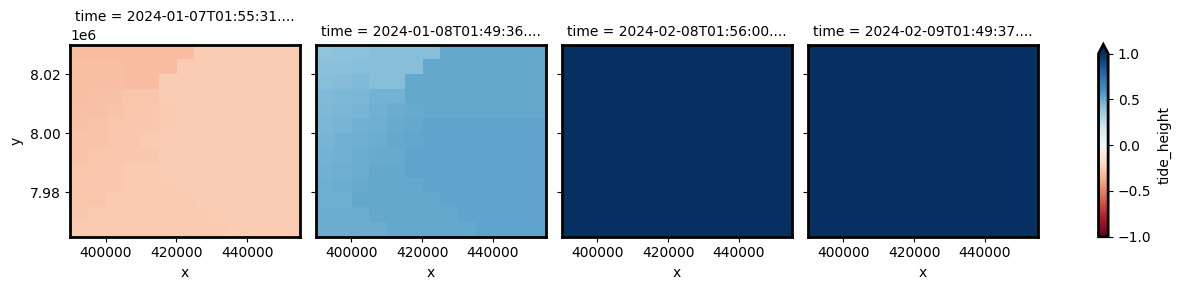

In [12]:
# Plot the first four timesteps in our data
tides_lowres.isel(time=slice(0, 4)).plot.imshow(col="time", vmin=-1, vmax=1, cmap="RdBu")

### Reprojecting into original high-resolution spatial grid

By setting `resample=True`, we can use interpolation to re-project our low resolution tide data back into the resolution of our satellite image, resulting in an individual **tide height for every pixel** in our dataset through time and space:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Reprojecting tides into original resolution


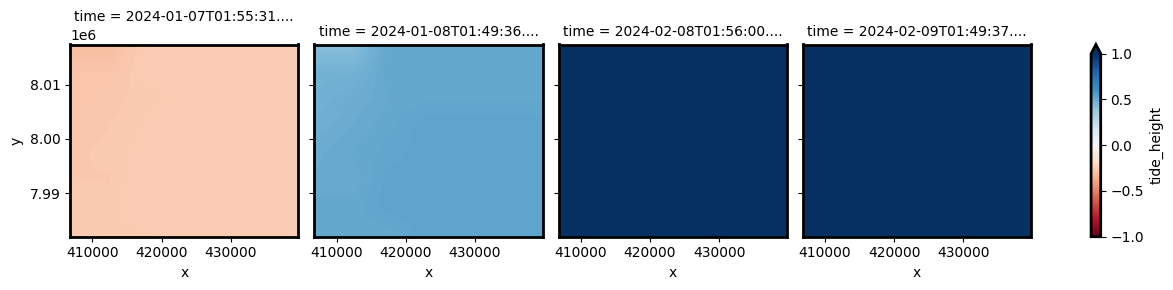

In [13]:
# Model tides spatially
tides_highres = pixel_tides(
    ds=ds,
    resample=True,
    directory="../../tests/data/tide_models",
)

# Plot the first four timesteps in our data
tides_highres.isel(time=slice(0, 4)).plot.imshow(col="time", vmin=-1, vmax=1, cmap="RdBu")

`tides_highres` will have exactly the same dimensions as `ds`, with a unique tide height for every satellite pixel:

In [14]:
ds.sizes

Frozen({'y': 1185, 'x': 1099, 'time': 44})

In [15]:
tides_highres.sizes

Frozen({'time': 44, 'y': 1185, 'x': 1099})

Because of this, our stack of tides can be added as an additional 3D variable in our dataset:

In [16]:
ds["tide_height_pixel"] = tides_highres
print(ds)

<xarray.Dataset> Size: 917MB
Dimensions:            (y: 1185, x: 1099, time: 44)
Coordinates:
  * y                  (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06
  * x                  (x) float64 9kB 4.068e+05 4.068e+05 ... 4.398e+05
    spatial_ref        int32 4B 32751
  * time               (time) datetime64[ns] 352B 2024-01-07T01:55:31.679580 ...
    tide_model         <U5 20B 'EOT20'
Data variables:
    nbart_red          (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_green        (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    nbart_blue         (time, y, x) float32 229MB dask.array<chunksize=(1, 1185, 1099), meta=np.ndarray>
    tide_height_pixel  (time, y, x) float32 229MB -0.3038 -0.3039 ... -0.03352


### Calculating tide height min/max/median/quantiles for each pixel
Min, max or any specific quantile of all tide heights observed over a region can be calculated for each pixel by passing in a list of quantiles/percentiles using the `calculate_quantiles` parameter.

This calculation is performed on the low resolution modelled tide data before reprojecting to higher resolution, so should be faster than calculating min/max/median tide at high resolution:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


Computing tide quantiles
Reprojecting tides into original resolution


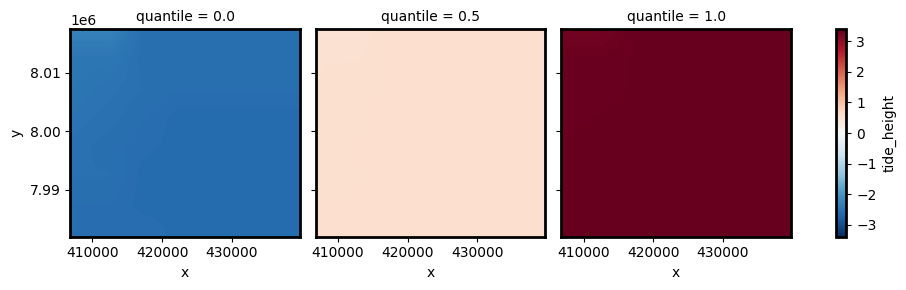

In [17]:
# Model tides spatially
tides_highres_quantiles = pixel_tides(
    ds=ds,
    calculate_quantiles=(0, 0.5, 1),
    directory="../../tests/data/tide_models",
)

# Plot quantiles
tides_highres_quantiles.plot.imshow(col="quantile")

### Modelling custom times

Instead of using times contained in the `time` dimension of our dataset, we can also calculate pixel-based tides for a custom set of times:

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00,  9.55it/s]


Reprojecting tides into original resolution


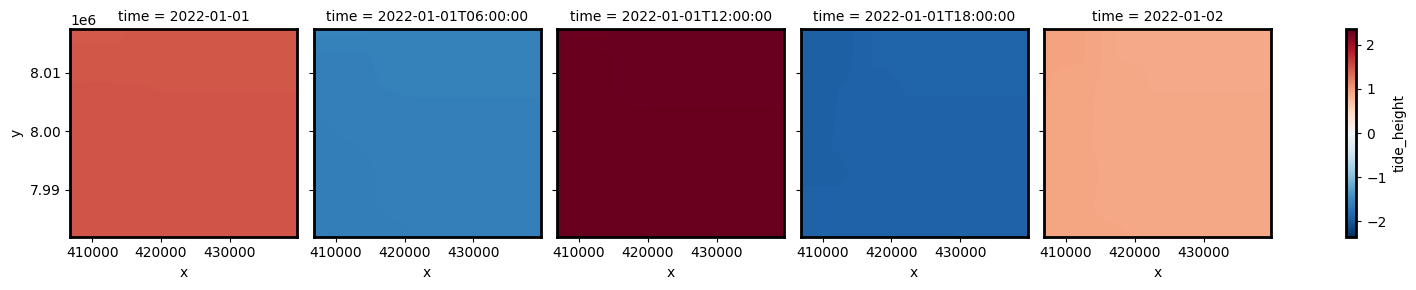

In [18]:
import pandas as pd

custom_times = pd.date_range(
    start="2022-01-01", 
    end="2022-01-02", 
    freq="6H",
)

# Model tides spatially
tides_highres = pixel_tides(
    ds, 
    times=custom_times,
    directory="../../tests/data/tide_models",
)

# Plot custom timesteps
tides_highres.plot.imshow(col="time")

## Next steps

Now that we have learnt to combine tide modelling with satellite data, we can learn how to [calculate statistics](../Tide_statistics) describing local tide dynamics, as well as biases caused by interactions between tidal processes and satellite orbits.